In [3]:
% matplotlib inline
from __future__ import print_function

from rankpruning import RankPruning, other_pnlearning_methods
import numpy as np

# Libraries uses only for the purpose of the tutorial
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.metrics import accuracy_score as acc
import pandas as pd
from sklearn.linear_model import LogisticRegression

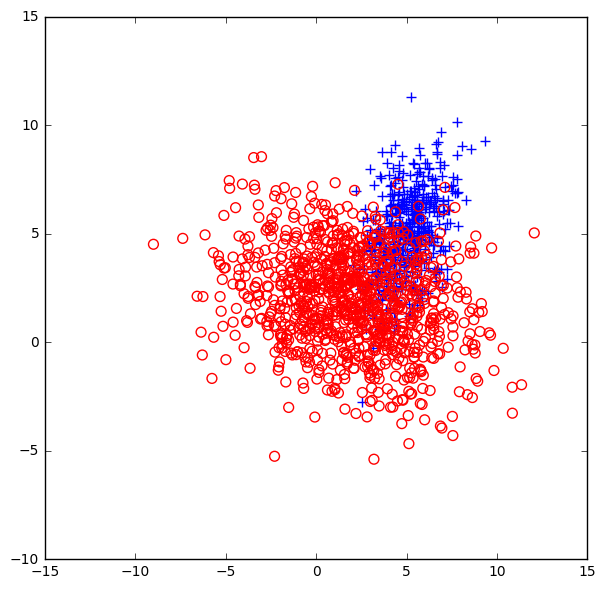

In [2]:
# Create our training dataset having examples drawn from two 2-dimensional Guassian distributions.
# A Pandas DataFrame is used only for the purposes of demonstration. Numpy arrays are preferred.
# In this example, we allow for class imbalance (twice as many negative examples).
neg = pd.DataFrame(multivariate_normal.rvs(mean=[2,2], cov=[[10,-1.5],[-1.5,5]], size=1000), columns = ['x1', 'x2'])
neg['label'] = [0 for i in range(len(neg))]
pos = pd.DataFrame(multivariate_normal.rvs(mean=[5,5], cov=[[1.5,0.3],[1.3,4]], size=500), columns = ['x1', 'x2'])
pos['label'] = [1 for i in range(len(pos))]

# Plot the distribution for your viewing.
plt.figure(figsize=(7, 7))
plt.scatter(pos['x1'], pos['x2'], c='blue', s=50, marker="+", linewidth=1)
plt.scatter(neg['x1'], neg['x2'], s=50, facecolors='none', edgecolors='red', linewidth=1)

## Let's look at seemingly impossible example where 80% of hidden, true positive labels have been flipped to negative! Also, let 15% of negative labels be flipped to positive!

### Feel free to adjust these noise rates. But remember --> frac_neg2pos + frac_neg2pos < 1, i.e. $\rho_1 + \rho_0 < 1$

In [34]:
# Choose mislabeling noise rates.
frac_pos2neg = 0.8 # rh1, P(s=0|y=1) in literature
frac_neg2pos = 0.15 # rh0, P(s=1|y=0) in literature

# Combine data into training examples and labels
data = neg.append(pos)
X = data[["x1","x2"]].values
y = data["label"].values

# Noisy P̃Ñ learning: instead of target y, we have s containing mislabeled examples.
# First, we flip positives, then negatives, then combine.
# We assume labels are flipped by some noise process uniformly randomly within each class.
s = y * (np.cumsum(y) <= (1 - frac_pos2neg) * sum(y))
s_only_neg_mislabeled = 1 - (1 - y) * (np.cumsum(1 - y) <= (1 - frac_neg2pos) * sum(1 - y))
s[y==0] = s_only_neg_mislabeled[y==0]

In [35]:
# Create testing dataset
neg_test = multivariate_normal.rvs(mean=[2,2], cov=[[10,-1.5],[-1.5,5]], size=2000)
pos_test = multivariate_normal.rvs(mean=[5,5], cov=[[1.5,1.3],[1.3,4]], size=1000)
X_test = np.concatenate((neg_test, pos_test))
y_test = np.concatenate((np.zeros(len(neg_test)), np.ones(len(pos_test))))

In [36]:
# Create and fit Rank Pruning object using any clf 
# of your choice as long as it has predict_proba() defined
rp = RankPruning(clf = LogisticRegression())
# rp.fit(X, s, positive_lb_threshold=1-frac_pos2neg, negative_ub_threshold=frac_neg2pos) 
rp.fit(X, s)

In [37]:
actual_py1 = sum(y) / float(len(y))
actual_ps1 = sum(s) / float(len(s))
actual_pi1 = frac_neg2pos * (1 - actual_py1) / float(actual_ps1)
actual_pi0 = frac_pos2neg * actual_py1 / (1 - actual_ps1)

In [38]:
print("What are rho1, rho0, pi1, and pi0?")
print("----------------------------------")
print("rho1 (frac_pos2neg) is the fraction of positive examples mislabeled as negative examples.")
print("rho0 (frac_neg2pos) is the fraction of negative examples mislabeled as positive examples.")
print("pi1 is the fraction of mislabeled examples in observed noisy P.")
print("pi0 is the fraction of mislabeled examples in observed noisy N.")
print()
print("Given (rho1, pi1), (rho1, rho), (rho0, pi0), or (pi0, pi1) the other two are known.")
print()
print("Using Rank Pruning, we estimate rho1, rh0, pi1, and pi0:")
print("--------------------------------------------------------------")
print("Estimated rho1, P(s = 0 | y = 1):", round(rp.rh1, 2), "\t| Actual:", round(frac_pos2neg, 2))
print("Estimated rho0, P(s = 1 | y = 0):", round(rp.rh0, 2), "\t| Actual:", round(frac_neg2pos, 2))
print("Estimated pi1, P(y = 0 | s = 1):", round(rp.pi1, 2), "\t| Actual:", round(actual_pi1, 2))
print("Estimated pi0, P(y = 1 | s = 0):", round(rp.pi0, 2), "\t| Actual:", round(actual_pi0, 2))
print("Estimated py1, P(y = 1):", round(rp.py1, 2), "\t\t| Actual:", round(actual_py1, 2))

What are rho1, rho0, pi1, and pi0?
----------------------------------
rho1 (frac_pos2neg) is the fraction of positive examples mislabeled as negative examples.
rho0 (frac_neg2pos) is the fraction of negative examples mislabeled as positive examples.
pi1 is the fraction of mislabeled examples in observed noisy P.
pi0 is the fraction of mislabeled examples in observed noisy N.

Given (rho1, pi1), (rho1, rho), (rho0, pi0), or (pi0, pi1) the other two are known.

Using Rank Pruning, we estimate rho1, rh0, pi1, and pi0:
--------------------------------------------------------------
Estimated rho1, P(s = 0 | y = 1): 0.83 	| Actual: 0.8
Estimated rho0, P(s = 1 | y = 0): 0.17 	| Actual: 0.15
Estimated pi1, P(y = 0 | s = 1): 1.0 	| Actual: 0.6
Estimated pi0, P(y = 1 | s = 0): 0.0 	| Actual: 0.32
Estimated py1, P(y = 1): -0.02 		| Actual: 0.33


## Comparing models using a logistic regression classifier.

In [39]:
# For shorter notation use rh1 and rh0 for noise rates.

clf = LogisticRegression()
rh1 = frac_pos2neg
rh0 = frac_neg2pos

models = {
  "Rank Pruning" : RankPruning(clf = clf),
  "Baseline" : other_pnlearning_methods.BaselineNoisyPN(clf),
  "Rank Pruning (noise rates given)": RankPruning(rh1, rh0, clf),
  "Elk08 (noise rates given)": other_pnlearning_methods.Elk08(e1 = 1 - rh1, clf = clf),
  "Liu16 (noise rates given)": other_pnlearning_methods.Liu16(rh1, rh0, clf),
  "Nat13 (noise rates given)": other_pnlearning_methods.Nat13(rh1, rh0, clf),
}

for key in models.keys():
  model = models[key]
  model.fit(X, s)
  pred = model.predict(X_test)
  pred_proba = model.predict_proba(X_test) # Produces P(y=1|x)

  print("\n%s Model Performance:\n==============================\n" % key)
  print("Accuracy:", acc(y_test, pred))
  print("Precision:", prfs(y_test, pred)[0])
  print("Recall:", prfs(y_test, pred)[1])
  print("F1 score:", prfs(y_test, pred)[2])


Nat13 (noise rates given) Model Performance:

Accuracy: 0.808333333333
Precision: [ 0.8101872   0.80227596]
Recall: [ 0.9305  0.564 ]
F1 score: [ 0.86618571  0.66236054]

Baseline Model Performance:

Accuracy: 0.666666666667
Precision: [ 0.66666667  0.        ]
Recall: [ 1.  0.]
F1 score: [ 0.8  0. ]

Rank Pruning (noise rates given) Model Performance:

Accuracy: 0.814666666667
Precision: [ 0.83896714  0.75517241]
Recall: [ 0.8935  0.657 ]
F1 score: [ 0.8653753  0.7026738]

Elk08 (noise rates given) Model Performance:

Accuracy: 0.333333333333
Precision: [ 0.          0.33333333]
Recall: [ 0.  1.]
F1 score: [ 0.   0.5]

Rank Pruning Model Performance:

Accuracy: 0.831
Precision: [ 0.87083954  0.74974671]
Recall: [ 0.8765  0.74  ]
F1 score: [ 0.8736606   0.74484147]

Liu16 (noise rates given) Model Performance:

Accuracy: 0.414333333333
Precision: [ 1.          0.36271309]
Recall: [ 0.1215  1.    ]
F1 score: [ 0.2166741   0.53233963]


## Comparing models using a CNN classifier.
### Note, this particular CNN's architecture is for MNIST / CIFAR image detection and may not be appropriate for this synthetic dataset. A simple, fully connected regular deep neural network is likely suitable. We only use it here for the purpose of showing that Rank Pruning works for any probabilistic classifier, as long as it has clf.predict(), clf.predict_proba(), and clf.fit() defined.
### This section requires keras and tensorflow packages installed. See git repo for instructions in README.

In [89]:
num_features = 100

# Create training dataset - this synthetic dataset is not necessarily  
# appropriate for the CNN. This is for demonstrative purposes. 
# A fully connected regular neural network is more appropriate.
neg = multivariate_normal.rvs(mean=[0]*num_features, size=5000)
pos = multivariate_normal.rvs(mean=[0.5]*num_features, size=4000)
X = np.concatenate((neg, pos))
y = np.concatenate((np.zeros(len(neg)), np.ones(len(pos))))
# Again, s is the noisy labels, we flip y randomly using noise rates.
s = y * (np.cumsum(y) <= (1 - frac_pos2neg) * sum(y))
s_only_neg_mislabeled = 1 - (1 - y) * (np.cumsum(1 - y) <= (1 - frac_neg2pos) * sum(1 - y))
s[y==0] = s_only_neg_mislabeled[y==0]

# Create testing dataset
neg_test = multivariate_normal.rvs(mean=[0]*num_features, size=1000)
pos_test = multivariate_normal.rvs(mean=[0.4]*num_features, size=800)
X_test = np.concatenate((neg_test, pos_test))
y_test = np.concatenate((np.zeros(len(neg_test)), np.ones(len(pos_test))))

In [90]:
from classifier_cnn import CNN
clf = CNN(img_shape = (num_features/10, num_features/10), epochs = 1)

rh1 = frac_pos2neg
rh0 = frac_neg2pos

models = {
  "Rank Pruning" : RankPruning(clf = clf),
  "Baseline" : other_pnlearning_methods.BaselineNoisyPN(clf),
  "Rank Pruning (noise rates given)": RankPruning(rh1, rh0, clf),
  "Elk08 (noise rates given)": other_pnlearning_methods.Elk08(e1 = 1 - rh1, clf = clf),
  "Liu16 (noise rates given)": other_pnlearning_methods.Liu16(rh1, rh0, clf),
  "Nat13 (noise rates given)": other_pnlearning_methods.Nat13(rh1, rh0, clf),
}

print("Train all models first. Results will print at end.")

preds = {}
for key in models.keys():
  print("Training model: ", key)
  model = models[key]
  model.fit(X, s)
  pred = model.predict(X_test)
  pred_proba = model.predict_proba(X_test) # Produces P(y=1|x)
  preds[key] = pred

print("Comparing models using a CNN classifier.")
    
for key in models.keys():
  pred = preds[key]
  print("\n%s Model Performance:\n==============================\n" % key)
  print("Accuracy:", acc(y_test, pred))
  print("Precision:", prfs(y_test, pred)[0])
  print("Recall:", prfs(y_test, pred)[1])
  print("F1 score:", prfs(y_test, pred)[2])

Train all models first. Results will print at end.
Training model:  Nat13 (noise rates given)
Epoch 1/1
9000/9000 [==============================] - 5s - loss: 0.1991 - acc: 0.5423       